# Quantum Approximate Optimization Algorithm 

Qiskit has an implementation of the Quantum Approximate Optimization Algorithm [QAOA](https://qiskit.org/documentation/stubs/qiskit.algorithms.minimum_eigensolvers.QAOA.html) and this notebook demonstrates using it for a graph partition problem.

Before we begin, let's import the `annotations` module from `__future__` to allow postponed evaluation of annotations. This enables us to use simpler type hints throughout the notebook.

In [1]:
from __future__ import annotations

First we create a graph and draw it so it can be seen.

In [2]:
import numpy as np
import networkx as nx

num_nodes = 4
w = np.array([[0., 1., 1., 0.],
              [1., 0., 1., 1.],
              [1., 1., 0., 1.],
              [0., 1., 1., 0.]])
G = nx.from_numpy_array(w)

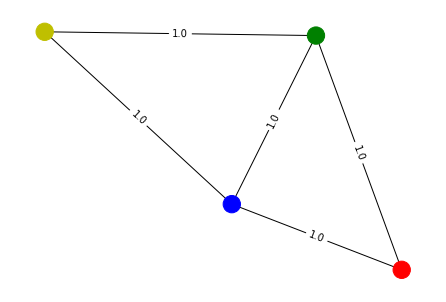

In [3]:
layout = nx.random_layout(G, seed=10)
colors = ['r', 'g', 'b', 'y']
nx.draw(G, layout, node_color=colors)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos=layout, edge_labels=labels);

The brute-force method is as follows. Basically, we exhaustively try all the binary assignments. In each binary assignment, the entry of a vertex is either 0 (meaning the vertex is in the first partition) or 1 (meaning the vertex is in the second partition). We print the binary assignment that satisfies the definition of the graph partition and corresponds to the minimal number of crossing edges.

In [4]:
def objective_value(x: np.ndarray, w: np.ndarray) -> float:
    """Compute the value of a cut.
    Args:
        x: Binary string as numpy array.
        w: Adjacency matrix.
    Returns:
        Value of the cut.
    """
    X = np.outer(x, (1 - x))
    w_01 = np.where(w != 0, 1, 0)
    return np.sum(w_01 * X)

def bitfield(n: int, L: int) -> list[int]:
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part

# use the brute-force way to generate the oracle
L = num_nodes
max = 2**L
sol = np.inf
for i in range(max):
    cur = bitfield(i, L)

    how_many_nonzero = np.count_nonzero(cur)
    if how_many_nonzero * 2 != L:  # not balanced
        continue

    cur_v = objective_value(np.array(cur), w)
    if cur_v < sol:
        sol = cur_v

print(f'Objective value computed by the brute-force method is {sol}')

Objective value computed by the brute-force method is 3


The graph partition problem can be converted to an Ising Hamiltonian. Qiskit has different capabilities in the Optimization module to do this. Here, since the goal is to show QAOA, the module is used without further explanation to create the operator. The paper [Ising formulations of many NP problems](https://arxiv.org/abs/1302.5843) may be of interest if you would like to understand the technique further.

In [5]:
from qiskit.quantum_info import Pauli, SparsePauliOp

def get_operator(weight_matrix: np.ndarray) -> tuple[SparsePauliOp, float]:
    r"""Generate Hamiltonian for the graph partitioning
    Notes:
        Goals:
            1 Separate the vertices into two set of the same size.
            2 Make sure the number of edges between the two set is minimized.
        Hamiltonian:
            H = H_A + H_B
            H_A = sum\_{(i,j)\in E}{(1-ZiZj)/2}
            H_B = (sum_{i}{Zi})^2 = sum_{i}{Zi^2}+sum_{i!=j}{ZiZj}
            H_A is for achieving goal 2 and H_B is for achieving goal 1.
    Args:
        weight_matrix: Adjacency matrix.
    Returns:
        Operator for the Hamiltonian
        A constant shift for the obj function.
    """
    num_nodes = len(weight_matrix)
    pauli_list = []
    coeffs = []
    shift = 0

    for i in range(num_nodes):
        for j in range(i):
            if weight_matrix[i, j] != 0:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(-0.5)
                shift += 0.5

    for i in range(num_nodes):
        for j in range(num_nodes):
            if i != j:
                x_p = np.zeros(num_nodes, dtype=bool)
                z_p = np.zeros(num_nodes, dtype=bool)
                z_p[i] = True
                z_p[j] = True
                pauli_list.append(Pauli((z_p, x_p)))
                coeffs.append(1.0)
            else:
                shift += 1
                
    return SparsePauliOp(pauli_list, coeffs=coeffs), shift

qubit_op, offset = get_operator(w)

So lets use the QAOA algorithm to find the solution.

In [6]:
from qiskit.algorithms.minimum_eigensolvers import QAOA
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal
from qiskit.primitives import Sampler
from qiskit.quantum_info import Pauli, Statevector
from qiskit.result import QuasiDistribution
from qiskit.utils import algorithm_globals

sampler = Sampler()


def sample_most_likely(state_vector: QuasiDistribution | Statevector) -> np.ndarray:
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)

algorithm_globals.random_seed = 10598

optimizer = COBYLA()
qaoa = QAOA(sampler, optimizer, reps=2)

result = qaoa.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f'Objective value computed by QAOA is {objective_value(x, w)}')

[1 1 0 0]
Objective value computed by QAOA is 3


The outcome can be seen to match to the value computed above by brute force. But we can also use the classical `NumPyMinimumEigensolver` to do the computation, which may be useful as a reference without doing things by brute force.

In [7]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit.quantum_info import Operator

npme = NumPyMinimumEigensolver()
result = npme.compute_minimum_eigenvalue(Operator(qubit_op))

x = sample_most_likely(result.eigenstate)

print(x)
print(f'Objective value computed by the NumPyMinimumEigensolver is {objective_value(x, w)}')

[1 1 0 0]
Objective value computed by the NumPyMinimumEigensolver is 3


It is also possible to use VQE as is shown below

In [8]:
from qiskit.algorithms.minimum_eigensolvers import SamplingVQE
from qiskit.circuit.library import TwoLocal
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 10598

optimizer = COBYLA()
ansatz = TwoLocal(qubit_op.num_qubits, "ry", "cz", reps=2, entanglement="linear")
sampling_vqe = SamplingVQE(sampler, ansatz, optimizer)

result = sampling_vqe.compute_minimum_eigenvalue(qubit_op)

x = sample_most_likely(result.eigenstate)

print(x)
print(f"Objective value computed by VQE is {objective_value(x, w)}")


[0 1 0 1]
Objective value computed by VQE is 3


In [9]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright